In [2]:
from glob import glob
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from statsmodels.sandbox.stats.multicomp import multipletests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.stats.composition import clr
from matplotlib_venn import venn3

sns.set_context('talk')
sns.set(rc={"figure.dpi":150, 'savefig.dpi':300})
sns.set_style('whitegrid')

def p_adjust(pvalues, method='fdr_bh'):
    res = multipletests(pvalues, method=method)
    return np.array(res[1], dtype=float)

# Metabolomics correlations
##### 7/18/22
##### Michael Shaffer
##### Merck ESC, Sys bio group

After some success with correlating KOs with continuous titer we decided to use the same approach on the metabolomics data. This data table came from Tom directly.

## Read in data

Read in the excel table from Tom and fill out empty cells with zeros.

In [3]:
metab_data = pd.read_excel('../../data/metabolomics_abunds.xlsx', index_col=0).fillna(0)
metab_data = metab_data.drop('2-Methyl-1-butanol', axis=1) # drop 2-methyl-1-butanol
metab_data.head()

,GCDCA,GDCA,GHDCA or GUDCA,CA,TCDCA,TCA,CDCA,7oxoCA,TUDCA,UDCA or HDCA,...,Uracil,Adenosine,Phenaceturic acid,N-Acetyl D-galactosamine,Pyridoxal hydrochloride,2-Deoxyuridine,Vanillic acid,Thymine,Nicotinic acid,Homocitrate
Compound name,,,,,,,,,,,,,,,,,,,,,
P103_V12_05052020,13165.576990,6486.205847,1037.427698,877.477368,842.441112,428.399288,412.663454,6.309238,26.103778,37.617317,...,571,112,45,90,426,1223,6865,549,217,3044
P106_V9_04022019,5324.081005,615.267690,1431.812977,536.910350,477.807838,761.254736,55.773899,4.142229,91.815489,19.861706,...,400,368,206,217,201,372,53,230,216,109
P107_A1_04152019,11967.195030,3.048386,8876.579286,884.309058,2720.613568,3492.197205,106.185518,7.807234,664.956760,113.460800,...,594,112,8,330,102,9,87,55,177,6952
P108_V9_04022019,117.128627,-0.240781,116.125243,29.790592,6.916959,5.775257,1.574994,0.418815,1.671431,4.996911,...,60,226,11,16,249,104,64,18,24,36
P108_V12_05212020,16651.224940,1707.969274,3575.590198,1277.281488,2356.663104,1109.351448,204.781749,41.696046,216.707453,107.961759,...,375,184,205,141,253,702,298,196,196,3468


In [3]:
len(metab_data.columns)

111

111 total compounds.

In [4]:
(metab_data < 0).sum().sum()

34

There are only 34 negative values in the data set so not much to worry about.

In [5]:
metab_data.unstack()[metab_data.unstack() < 0]

        Compound name    
GDCA    P108_V9_04022019    -0.240781
        P134_V9_12062019    -3.462650
        P136_V9_01092020    -3.398780
        P136_V12_01042021   -0.059861
        P202_V12_02252020   -1.708202
        P212_V5_05232018    -2.539283
        P215_V9_03292019    -4.984036
        P215_V12_03302020   -2.424750
        P217_V5_06122018    -1.613075
        P217_V9_04122019    -0.517431
        P218_V5_06062018    -0.427326
        P220_V5_06132018    -0.218075
        P224_V9_05292019    -0.396865
        P229_V5_07022018    -0.664653
        P235_V5_08152018    -0.203266
        P237_V9_06242019    -0.407863
        P239_V5_08292018    -0.942639
        P246_V10_10032019   -1.541833
        P250_V5_11062018    -1.424605
        P250_V9_09092019    -2.380330
        P252_V9_09102019    -1.033160
        P256_V9_10082018    -0.539685
        P258_V5_01032019    -1.193836
        P260_V9_11072019    -7.410659
        P261_V5_01032019    -2.489533
        P263_V9_11262019

There are negative numbers in the data set. Checked with Tom and he said that these can be treated as zeros. So do that.

In [6]:
# Replace negative numbers with 0 as Tom said in an email
metab_data[metab_data < 0] = 0
(metab_data == 0).sum().sum()

38

Relative abundance normalized version of table is calculated by summing rows and dividing column values by totals. Makes it so that values are percent abundances of sample.

In [7]:
metab_data_rel = metab_data.div(metab_data.sum(axis=1), axis=0)
metab_data_rel.head()

,GCDCA,GDCA,GHDCA or GUDCA,CA,TCDCA,TCA,CDCA,7oxoCA,TUDCA,UDCA or HDCA,...,Uracil,Adenosine,Phenaceturic acid,N-Acetyl D-galactosamine,Pyridoxal hydrochloride,2-Deoxyuridine,Vanillic acid,Thymine,Nicotinic acid,Homocitrate
Compound name,,,,,,,,,,,,,,,,,,,,,
P103_V12_05052020,0.001680,8.275956e-04,0.000132,0.000112,0.000107,0.000055,5.265304e-05,8.050157e-07,3.330664e-06,0.000005,...,0.000073,0.000014,0.000006,0.000011,0.000054,0.000156,0.000876,0.000070,0.000028,0.000388
P106_V9_04022019,0.000847,9.783810e-05,0.000228,0.000085,0.000076,0.000121,8.869005e-06,6.586853e-07,1.460024e-05,0.000003,...,0.000064,0.000059,0.000033,0.000035,0.000032,0.000059,0.000008,0.000037,0.000034,0.000017
P107_A1_04152019,0.002120,5.401497e-07,0.001573,0.000157,0.000482,0.000619,1.881523e-05,1.383380e-06,1.178250e-04,0.000020,...,0.000105,0.000020,0.000001,0.000058,0.000018,0.000002,0.000015,0.000010,0.000031,0.001232
P108_V9_04022019,0.000065,0.000000e+00,0.000065,0.000017,0.000004,0.000003,8.751132e-07,2.327061e-07,9.286966e-07,0.000003,...,0.000033,0.000126,0.000006,0.000009,0.000138,0.000058,0.000036,0.000010,0.000013,0.000020
P108_V12_05212020,0.002614,2.681638e-04,0.000561,0.000201,0.000370,0.000174,3.215225e-05,6.546587e-06,3.402467e-05,0.000017,...,0.000059,0.000029,0.000032,0.000022,0.000040,0.000110,0.000047,0.000031,0.000031,0.000545


CLR normalized version of table is calculated using CLR (centered log ratio transformation) which controls for compositionality. This is done using the scikit-bio package.

In [8]:
metab_data_clr = pd.DataFrame(clr(metab_data + .001), index=metab_data.index, columns=metab_data.columns)

Build simple metadata table based on the sample names from the metabolomics table.

In [9]:
meta_rows = [[i, int(i.split('_')[0].strip('P')), i.split('_')[1], i.split('_')[-1]] for i in metab_data.index]
meta_base = pd.DataFrame(meta_rows, columns=['SampleID', 'BabyN', 'VisitCode', 'VisitDate']).set_index('SampleID')
meta_base.head()

,BabyN,VisitCode,VisitDate
SampleID,,,
P103_V12_05052020,103,V12,05052020
P106_V9_04022019,106,V9,04022019
P107_A1_04152019,107,A1,04152019
P108_V9_04022019,108,V9,04022019
P108_V12_05212020,108,V12,05212020


Connect sample data to 1 yr titer data via the baby numbers.

In [10]:
titer_data = pd.read_csv('../../data/vaccine_response/vaccine_response_y1.tsv', sep='\t', index_col=0)
titer_data.index = [int(i.split('Baby')[-1]) for i in titer_data.index]
titer_data.head()

,PT,Dip,FHA,PRN,TET,PRP (Hib),PCV ST1,PCV ST3,PCV ST4,PCV ST5,...,median_mmNorm_PCV,median_mmNorm_DTAPHib,protectNorm_Dip,protectNorm_TET,protectNorm_PRP (Hib),protectNorm_PT,protectNorm_PRN,protectNorm_FHA,geommean_protectNorm,VR_group_v2
106,2.5,0.21,11.0,2.5,0.30,0.39,141.0,35.0,56.0,139.0,...,0.061955,0.052874,2.1,3.0,2.600000,0.3125,0.3125,1.3750,1.140388,NVR
107,2.5,0.44,3.0,9.0,0.52,1.60,2430.0,415.0,194.0,332.0,...,0.958142,0.114018,4.4,5.2,10.666667,0.3125,1.1250,0.3750,1.783418,NVR
108,2.5,0.05,1.5,2.5,0.05,0.27,21.0,3.0,24.0,41.0,...,0.003102,0.000000,0.5,0.5,1.800000,0.3125,0.3125,0.1875,0.449420,LVR
109,27.0,NaN,NaN,63.0,1.35,7.02,NaN,NaN,NaN,NaN,...,0.486810,0.763049,NaN,13.5,46.800000,3.3750,7.8750,NaN,11.383505,HVR
110,14.0,0.24,15.0,20.0,2.45,NaN,301.0,63.0,400.0,289.0,...,0.245121,0.284211,2.4,24.5,NaN,1.7500,2.5000,1.8750,3.440894,HVR


Use BabyN to connect compound abundance to titer values since there is only one 2 month sample and one set of 1 year titer values per baby.

In [11]:
per_sample_titer_data = pd.DataFrame({sample: titer_data.loc[i] for sample, i in meta_base['BabyN'].iteritems() if i in titer_data.index}).transpose()
per_sample_titer_data.head()

,PT,Dip,FHA,PRN,TET,PRP (Hib),PCV ST1,PCV ST3,PCV ST4,PCV ST5,...,median_mmNorm_PCV,median_mmNorm_DTAPHib,protectNorm_Dip,protectNorm_TET,protectNorm_PRP (Hib),protectNorm_PT,protectNorm_PRN,protectNorm_FHA,geommean_protectNorm,VR_group_v2
P106_V9_04022019,2.5,0.21,11.0,2.5,0.3,0.39,141.0,35.0,56.0,139.0,...,0.061955,0.052874,2.1,3.0,2.6,0.3125,0.3125,1.375,1.140388,NVR
P107_A1_04152019,2.5,0.44,3.0,9.0,0.52,1.6,2430.0,415.0,194.0,332.0,...,0.958142,0.114018,4.4,5.2,10.666667,0.3125,1.125,0.375,1.783418,NVR
P108_V9_04022019,2.5,0.05,1.5,2.5,0.05,0.27,21.0,3.0,24.0,41.0,...,0.003102,0.0,0.5,0.5,1.8,0.3125,0.3125,0.1875,0.44942,LVR
P108_V12_05212020,2.5,0.05,1.5,2.5,0.05,0.27,21.0,3.0,24.0,41.0,...,0.003102,0.0,0.5,0.5,1.8,0.3125,0.3125,0.1875,0.44942,LVR
P110_V9_05172019,14.0,0.24,15.0,20.0,2.45,NaN,301.0,63.0,400.0,289.0,...,0.245121,0.284211,2.4,24.5,NaN,1.75,2.5,1.875,3.440894,HVR


Merge sample metadata and titer data, filter out samples without one year titers.

In [13]:
meta = pd.concat([meta_base, per_sample_titer_data], axis=1)
meta = meta.loc[~pd.isna(meta['VR_group'])]
meta.head()

,BabyN,VisitCode,VisitDate,PT,Dip,FHA,PRN,TET,PRP (Hib),PCV ST1,...,median_mmNorm_PCV,median_mmNorm_DTAPHib,protectNorm_Dip,protectNorm_TET,protectNorm_PRP (Hib),protectNorm_PT,protectNorm_PRN,protectNorm_FHA,geommean_protectNorm,VR_group_v2
P106_V9_04022019,106,V9,04022019,2.5,0.21,11.0,2.5,0.3,0.39,141.0,...,0.061955,0.052874,2.1,3.0,2.6,0.3125,0.3125,1.375,1.140388,NVR
P107_A1_04152019,107,A1,04152019,2.5,0.44,3.0,9.0,0.52,1.6,2430.0,...,0.958142,0.114018,4.4,5.2,10.666667,0.3125,1.125,0.375,1.783418,NVR
P108_V9_04022019,108,V9,04022019,2.5,0.05,1.5,2.5,0.05,0.27,21.0,...,0.003102,0.0,0.5,0.5,1.8,0.3125,0.3125,0.1875,0.44942,LVR
P108_V12_05212020,108,V12,05212020,2.5,0.05,1.5,2.5,0.05,0.27,21.0,...,0.003102,0.0,0.5,0.5,1.8,0.3125,0.3125,0.1875,0.44942,LVR
P110_V9_05172019,110,V9,05172019,14.0,0.24,15.0,20.0,2.45,NaN,301.0,...,0.245121,0.284211,2.4,24.5,NaN,1.75,2.5,1.875,3.440894,HVR


Find shared samples between the metadata and metabolomics data. Filter metadata to match the metabolomics.

In [14]:
in_both = list(set(meta.index) & set(metab_data.index))
meta_matched = meta.loc[in_both]
print(meta_matched.shape)

(141, 59)


In [15]:
meta_matched['VisitCode'].value_counts()

V9     52
V12    44
V5     36
V10     4
A1      2
A3      1
S3      1
A2      1
Name: VisitCode, dtype: int64

Plurality of samples from 1 year. Many from 2 months and 2 years as well. We will focus on two months (V5) and 1 year (V9).

## Do correlation with un-normalized data

First take the "raw" data (not further normalized from what Tom gave me) and correlate each feature with the mei.

### 2 months (V5) correlations

First focus on the 2 month time points.

We are using spearman for all of these correlations and multiple testing correction with Benjamini-Hochberg.

In [16]:
meta_v5 = meta_matched.query("VisitCode == 'V5'")
metab_data_v5 = metab_data.loc[meta_v5.index]
# metab_data_v5 = metab_data_v5[(metab_data_v5 > 0).sum(axis=0) > metab_data_v5.shape[0]*.2]
v5_correlations = metab_data_v5.apply(spearmanr, b=meta_v5['median_mmNorm']).transpose()
v5_correlations.columns = ['rho', 'p_value']
v5_correlations['p_adj'] = p_adjust(v5_correlations['p_value'])
v5_correlations = v5_correlations.sort_values('p_value')
print(len(v5_correlations), len(v5_correlations.query('p_value < .05')), len(v5_correlations.query('p_adj < .05')))
v5_correlations.head(14)

111 12 1


,rho,p_value,p_adj
Phenylpyruvic acid,-0.648906,0.000019,0.002067
Thymine,0.413824,0.012110,0.296791
Pyruvic acid,-0.401544,0.015208,0.296791
Inosine,-0.397169,0.016462,0.296791
Adenosine,-0.392841,0.017787,0.296791
Deoxycytidine 5-triphosphate,0.391248,0.018296,0.296791
5-HIAA,-0.389961,0.018717,0.296791
2-3-Dihydroxyisovalerate,-0.381388,0.021728,0.301481
2-Deoxyuridine,-0.355773,0.033210,0.362375
xanthurenic acid,-0.351351,0.035621,0.362375


13 compounds with raw p-values less than .05 and 1 compound with adjusted p-value less than .05.

Now save correlations to file.

#### Plot phenylpyruvic acid result

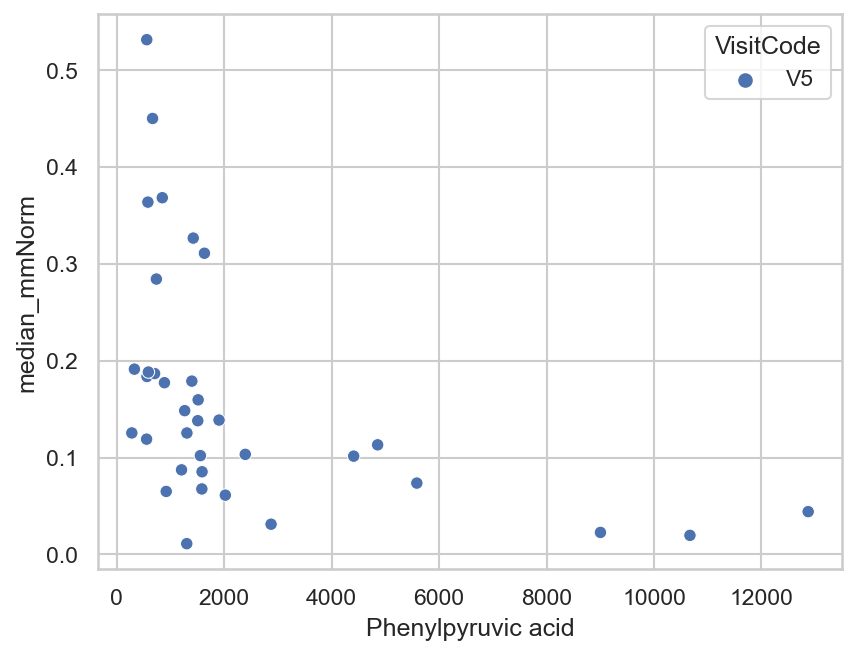

In [17]:
_ = sns.scatterplot(x='Phenylpyruvic acid', y='median_mmNorm', hue='VisitCode',
                   data=pd.concat([metab_data.loc[meta_matched.index], meta_matched], axis=1).query("VisitCode == 'V5'"))

Plot log phenylpyruvic acid abundance vs median normalized titer.

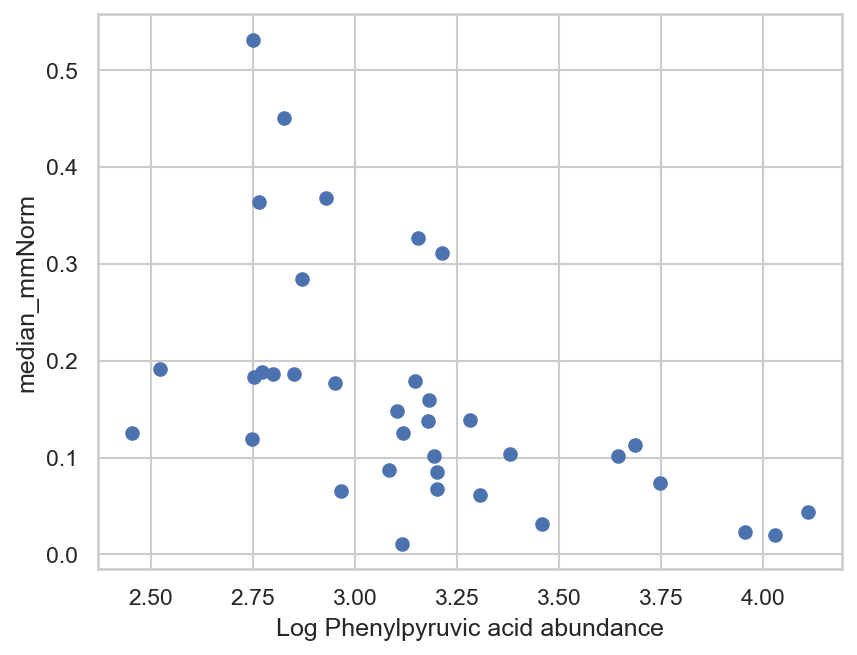

In [18]:
_ = plt.scatter(np.log10(metab_data.loc[meta_matched.query("VisitCode == 'V5'").index, 'Phenylpyruvic acid']), meta_matched.query("VisitCode == 'V5'")['median_mmNorm'])
_ = plt.xlabel('Log Phenylpyruvic acid abundance')
_ = plt.ylabel('median_mmNorm')

Plot ranks against each other since this is what spearman is actually using.

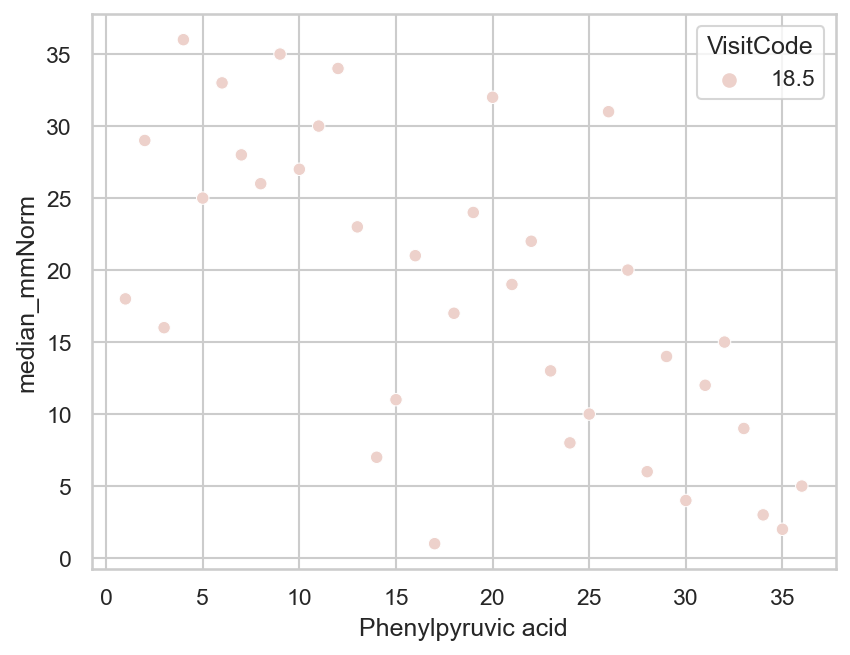

In [19]:
_ =sns.scatterplot(x='Phenylpyruvic acid', y='median_mmNorm', hue='VisitCode',
                   data=pd.concat([metab_data.loc[meta_matched.index], meta_matched], axis=1).query("VisitCode == 'V5'").rank())

### 1 year (V9) correlations

Same correlations but with year 1 un-normalized data.

In [20]:
meta_v9 = meta_matched.query("VisitCode == 'V9'")
metab_data_v9 = metab_data.loc[meta_v9.index]
# metab_data_v9 = metab_data_v9[(metab_data_v9 > 0).sum(axis=0) > metab_data_v9.shape[0]*.2]
v9_correlations = metab_data_v9.apply(spearmanr, b=meta_v9['median_mmNorm']).transpose()
v9_correlations.columns = ['rho', 'p_value']
v9_correlations = v9_correlations.loc[~pd.isna(v9_correlations['p_value'])]
v9_correlations['p_adj'] = p_adjust(v9_correlations['p_value'])
v9_correlations = v9_correlations.sort_values('p_value')
print(len(v9_correlations), len(v9_correlations.query('p_value < .05')), len(v9_correlations.query('p_adj < .05')))
v9_correlations.head(46)

111 62 45


,rho,p_value,p_adj
5-HIAA,0.515677,0.000091,0.003955
serotonin,0.506926,0.000126,0.003955
L-Isoleucine,0.496435,0.000182,0.003955
Xanthine,0.496339,0.000182,0.003955
L-Serine,0.491516,0.000215,0.003955
Guanosine,-0.487674,0.000245,0.003955
L-Proline,0.484045,0.000277,0.003955
Creatinine,0.483212,0.000285,0.003955
L-Phenylalanine,0.468208,0.000465,0.005731
L-Leucine,0.461430,0.000575,0.006385


45 compounds have significant adjusted p-values. 62 significant raw p-values. So about half of things are significant. Is this an artifact or does it mean that base metabolism is associated with titer response?

Tryptophan D5 is in this list. It is a control compound so we probably shouldn't trust this.

In [21]:
v9_correlations.loc[[i for i in v9_correlations.index if 'D5' in i]]

,rho,p_value,p_adj
L-tryptophan-D5,-0.339331,0.013856,0.038451


#### 5-HIAA

At 1 year correlation between 5-HIAA and median titer.

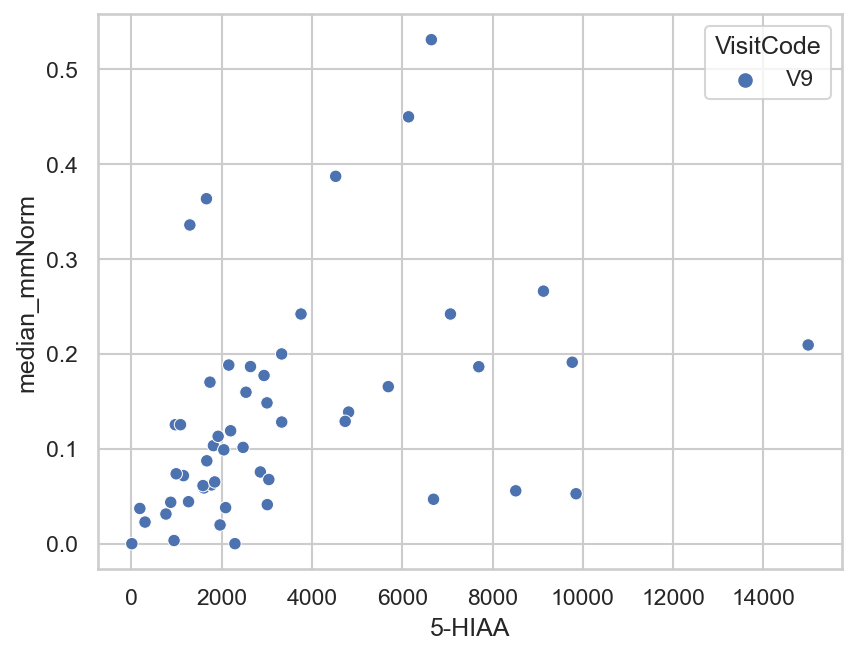

In [22]:
_ = sns.scatterplot(x='5-HIAA', y='median_mmNorm', hue='VisitCode',
                    data=pd.concat([metab_data.loc[meta_matched.index], meta_matched], axis=1).query("VisitCode == 'V9'"))

Scatter plot showing correlation between ranks and titer as that is what is actually measured.

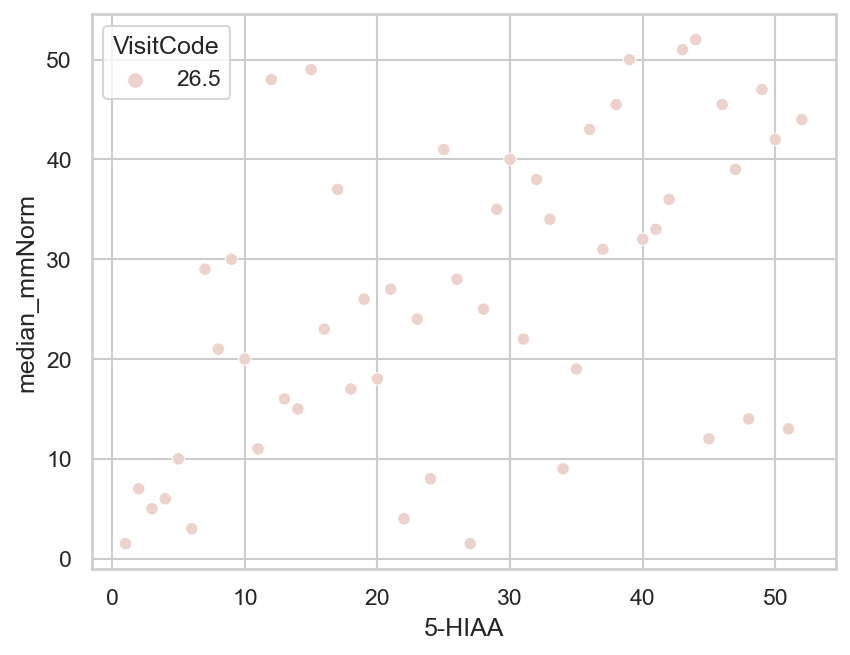

In [23]:
_ = sns.scatterplot(x='5-HIAA', y='median_mmNorm', hue='VisitCode',
                    data=pd.concat([metab_data.loc[meta_matched.index], meta_matched], axis=1).query("VisitCode == 'V9'").rank())

Scatterplot of 5-HIAA un-normalized vs median titer with points colored by visit code. V5 is 2 months and V9 is one year.

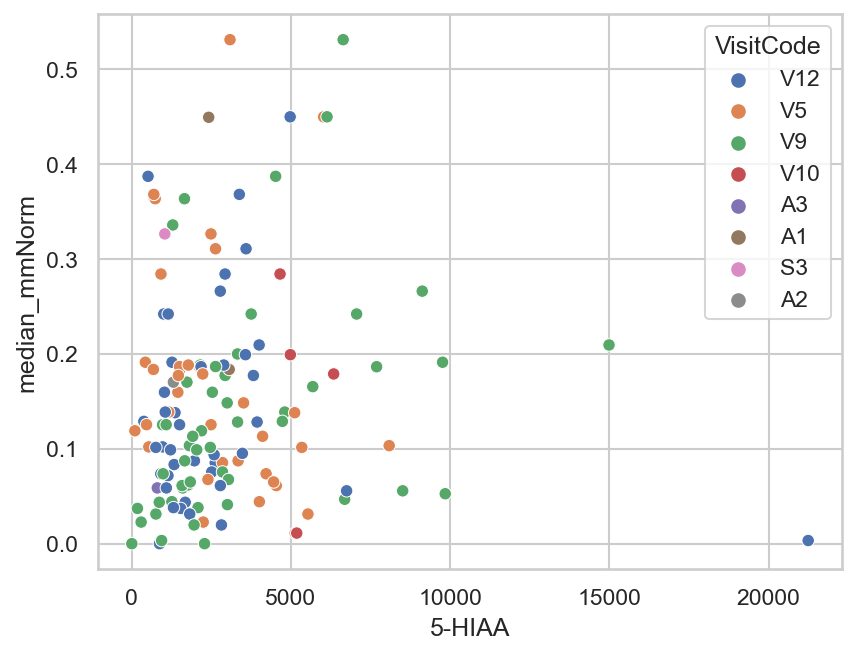

In [24]:
_ = sns.scatterplot(x='5-HIAA', y='median_mmNorm', hue='VisitCode',
                    data=pd.concat([metab_data.loc[meta_matched.index], meta_matched], axis=1))

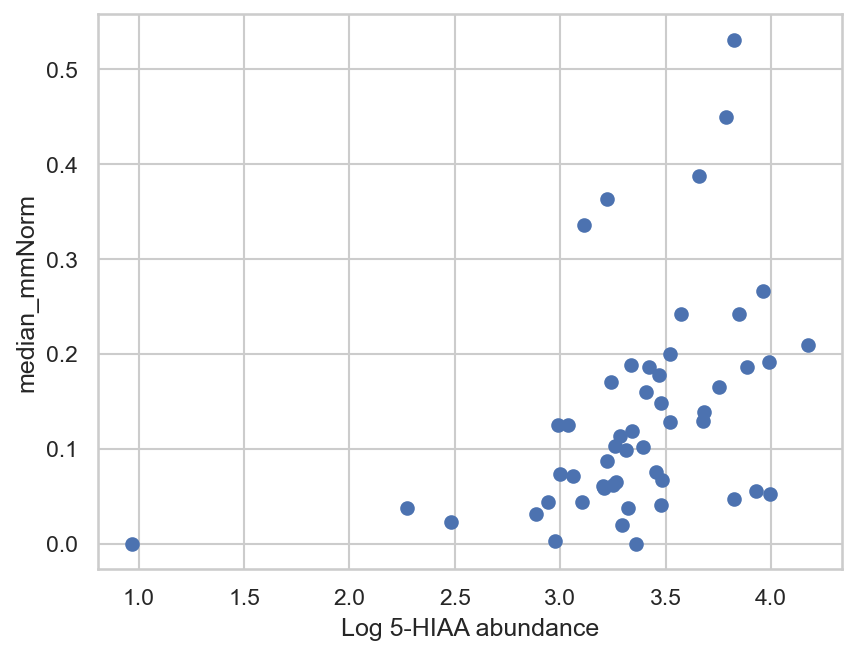

In [25]:
_ = plt.scatter(np.log10(metab_data.loc[meta_matched.query("VisitCode == 'V9'").index, '5-HIAA']), meta_matched.query("VisitCode == 'V9'")['median_mmNorm'])
_ = plt.xlabel('Log 5-HIAA abundance')
_ = plt.ylabel('median_mmNorm')

## Correlation with relative abundance data

Try normalizing metabolomics to relative abundance before doing correlations. Want to see if this will reduce number of correlated metabolites at 1 year.

In [26]:
metab_data_rel_v5 = metab_data_rel.loc[meta_v5.index]
# metab_data_v5 = metab_data_v5[(metab_data_v5 > 0).sum(axis=0) > metab_data_v5.shape[0]*.2]
v5_correlations_rel = metab_data_rel_v5.apply(spearmanr, b=meta_v5['median_mmNorm']).transpose()
v5_correlations_rel.columns = ['rho', 'p_value']
v5_correlations_rel['p_adj'] = p_adjust(v5_correlations_rel['p_value'])
v5_correlations_rel = v5_correlations_rel.sort_values('p_value')
v5_correlations_rel.head(15)

,rho,p_value,p_adj
Phenylpyruvic acid,-0.618018,0.000059,0.006561
Thymine,0.445817,0.006429,0.356798
myo-Inositol,0.377606,0.023179,0.483688
Adenosine,-0.374775,0.024317,0.483688
Inosine,-0.371686,0.025611,0.483688
5-HIAA,-0.367568,0.027425,0.483688
Pyruvic acid,-0.355212,0.033508,0.483688
4-Methyl-2-oxovaleric acid,0.335393,0.045535,0.483688
2-Deoxyuridine,-0.325611,0.052636,0.483688
Deoxycytidine 5-triphosphate,0.316345,0.060152,0.483688


Phenylpyruvic acide remains very significant at month 2 with no other significant results.

In [27]:
metab_data_rel_v9 = metab_data_rel.loc[meta_v9.index]
# metab_data_v9 = metab_data_v9[(metab_data_v9 > 0).sum(axis=0) > metab_data_v9.shape[0]*.2]
v9_correlations_rel = metab_data_rel_v9.apply(spearmanr, b=meta_v9['median_mmNorm']).transpose()
v9_correlations_rel.columns = ['rho', 'p_value']
v9_correlations_rel = v9_correlations_rel.loc[~pd.isna(v9_correlations_rel['p_value'])]
v9_correlations_rel['p_adj'] = p_adjust(v9_correlations_rel['p_value'])
v9_correlations_rel = v9_correlations_rel.sort_values('p_value')
v9_correlations_rel.head(30)

,rho,p_value,p_adj
D-Mannose,-0.559561,0.000016,0.000896
L-Sorbose,-0.559561,0.000016,0.000896
Guanosine,-0.525923,0.000062,0.002304
Adenosine,-0.501291,0.000153,0.004257
serotonin,0.488570,0.000238,0.005285
5-HIAA,0.473330,0.000394,0.006116
L-tryptophan-D5,-0.469702,0.000443,0.006116
L-Serine,0.468122,0.000466,0.006116
myo-Inositol,-0.466159,0.000496,0.006116
L-Isoleucine,0.455700,0.000687,0.007567


30 things significant at 12 months with relative abundance normalization. Down from 45 (out of 52).

## Correlation with CLR'd data

Now let's try with CLR adjusted data.

In [28]:
metab_data_clr_v5 = metab_data_clr.loc[meta_v5.index]
# metab_data_v5 = metab_data_v5[(metab_data_v5 > 0).sum(axis=0) > metab_data_v5.shape[0]*.2]
v5_correlations_clr = metab_data_clr_v5.apply(spearmanr, b=meta_v5['median_mmNorm']).transpose()
v5_correlations_clr.columns = ['rho', 'p_value']
v5_correlations_clr['p_adj'] = p_adjust(v5_correlations_clr['p_value'])
v5_correlations_clr = v5_correlations_clr.sort_values('p_value')
v5_correlations_clr.head(12)

,rho,p_value,p_adj
Phenylpyruvic acid,-0.637838,0.000029,0.003173
Thymine,0.474646,0.003446,0.191234
Creatine,0.411840,0.012571,0.382090
4-Pyridoxic acid,0.397426,0.016386,0.382090
Inosine,-0.391763,0.018130,0.382090
5-HIAA,-0.378893,0.022677,0.382090
Pyridoxal hydrochloride,0.366795,0.027776,0.382090
Adenosine,-0.363192,0.029466,0.382090
myo-Inositol,0.360103,0.030980,0.382090
L-tryptophan-D5,0.340026,0.042452,0.471219


Hooray! Still Phenylpyruvic acid and nothing else.

In [29]:
metab_data_clr_v9 = metab_data_clr.loc[meta_v9.index]
# metab_data_v9 = metab_data_v9[(metab_data_v9 > 0).sum(axis=0) > metab_data_v9.shape[0]*.2]
v9_correlations_clr = metab_data_clr_v9.apply(spearmanr, b=meta_v9['median_mmNorm']).transpose()
v9_correlations_clr.columns = ['rho', 'p_value']
v9_correlations_clr = v9_correlations_clr.loc[~pd.isna(v9_correlations_clr['p_value'])]
v9_correlations_clr['p_adj'] = p_adjust(v9_correlations_clr['p_value'])
v9_correlations_clr = v9_correlations_clr.sort_values('p_value')
v9_correlations_clr.head(22)

,rho,p_value,p_adj
Guanosine,-0.559604,0.000016,0.001788
Adenosine,-0.528185,0.000057,0.003170
Inosine,-0.492113,0.000211,0.006344
L-tryptophan-D5,-0.489765,0.000229,0.006344
serotonin,0.481313,0.000304,0.006740
L-Sorbose,-0.452285,0.000762,0.012084
D-Mannose,-0.452285,0.000762,0.012084
myo-Inositol,-0.444558,0.000961,0.013329
D-Xylose,-0.440289,0.001089,0.013434
5-HIAA,0.422360,0.001815,0.020142


Down to 21 significant things at 1 year with CLR so more "advanced" normalizations keep getting rid of significant results.

## Compare normalizations

To better understand what the normalization are shifting we compare between normalizations.

### V5

These are scatterplots of p-values between normalization at 2 months.

PearsonRResult(statistic=0.9127257622829813, pvalue=3.543830233449991e-44)

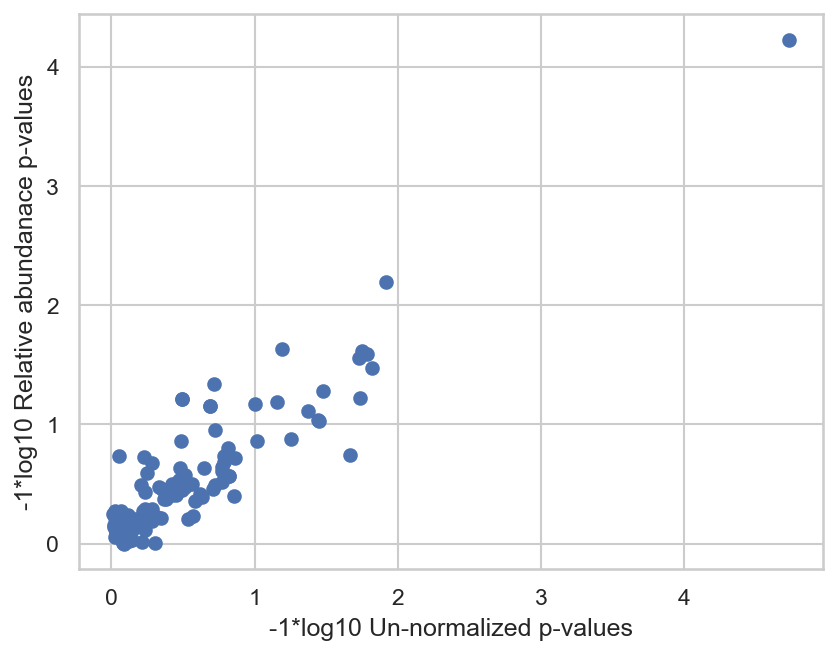

In [30]:
_ = plt.scatter(-1*np.log10(v5_correlations['p_value']), -1*np.log10(v5_correlations_rel.loc[v5_correlations.index, 'p_value']))
_ = plt.xlabel('-1*log10 Un-normalized p-values')
_ = plt.ylabel('-1*log10 Relative abundanace p-values')
pearsonr(-1*np.log10(v5_correlations['p_value']), -1*np.log10(v5_correlations_rel.loc[v5_correlations.index, 'p_value']))

Un-normalized and relative abundance are highly correlated but a bit of variance.

PearsonRResult(statistic=0.7195196445960201, pvalue=5.7807995753662e-19)

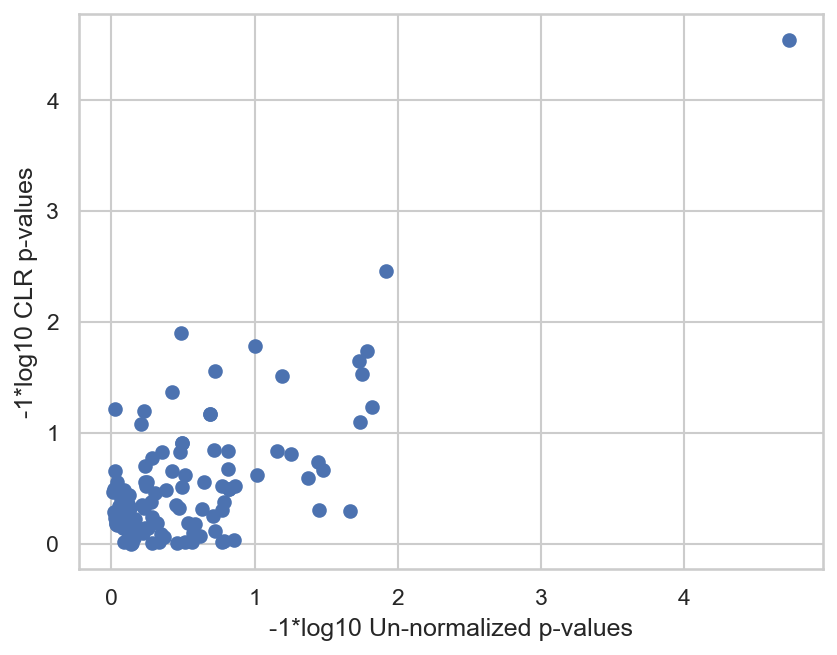

In [31]:
_ = plt.scatter(-1*np.log10(v5_correlations['p_value']), -1*np.log10(v5_correlations_clr.loc[v5_correlations.index, 'p_value']))
_ = plt.xlabel('-1*log10 Un-normalized p-values')
_ = plt.ylabel('-1*log10 CLR p-values')
pearsonr(-1*np.log10(v5_correlations['p_value']), -1*np.log10(v5_correlations_clr.loc[v5_correlations.index, 'p_value']))

Much more spread with un-normalized vs CLR.

PearsonRResult(statistic=0.8533849875294544, pvalue=1.2897044107726376e-32)

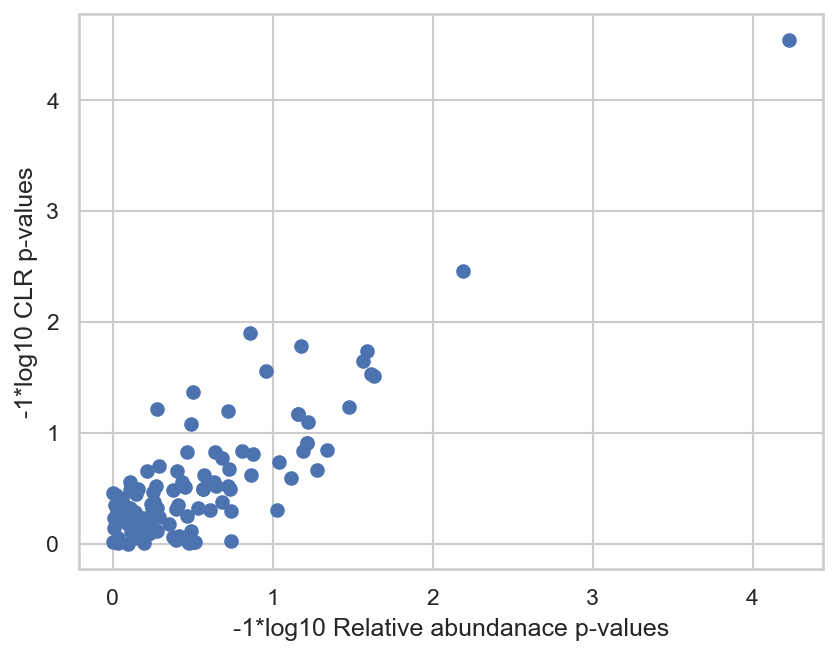

In [32]:
_ = plt.scatter(-1*np.log10(v5_correlations_rel['p_value']), -1*np.log10(v5_correlations_clr.loc[v5_correlations_rel.index, 'p_value']))
_ = plt.xlabel('-1*log10 Relative abundanace p-values')
_ = plt.ylabel('-1*log10 CLR p-values')
pearsonr(-1*np.log10(v5_correlations_rel['p_value']), -1*np.log10(v5_correlations_clr.loc[v5_correlations_rel.index, 'p_value']))

Less correlation between relative abundance and CLR but still pretty good.

Across all normalizations phenylpyruvic acid is super significant. You can definitely see that relative abundance and CLR shift the p-value distributions but they are much more strongly correlated with each other than the raw data.

### V9

Looking at the 1 year results.

To do:
* Try plotting L-tryptophan-D5, it is a standard, potentially use as a normalization factor (?)

In [33]:
set(v9_correlations.query('p_adj < .05').index) & set(v9_correlations_rel.query('p_adj < .05').index) & set(v9_correlations_clr.query('p_adj < .05').index)

{'5-HIAA',
 'Adenosine',
 'Guanosine',
 'Inosine',
 'L-Serine',
 'L-tryptophan-D5',
 'Mevalonic acid',
 'Phenaceturic acid',
 'serotonin'}

These are the 10 compounds that are significant in all 3 methods. The L-tryptophan-D5 is a spike-in. There are multiple spike-ins used and these is the only one that comes us as significant.

/Users/shaffmic/miniconda3/envs/imc/lib/python3.9/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


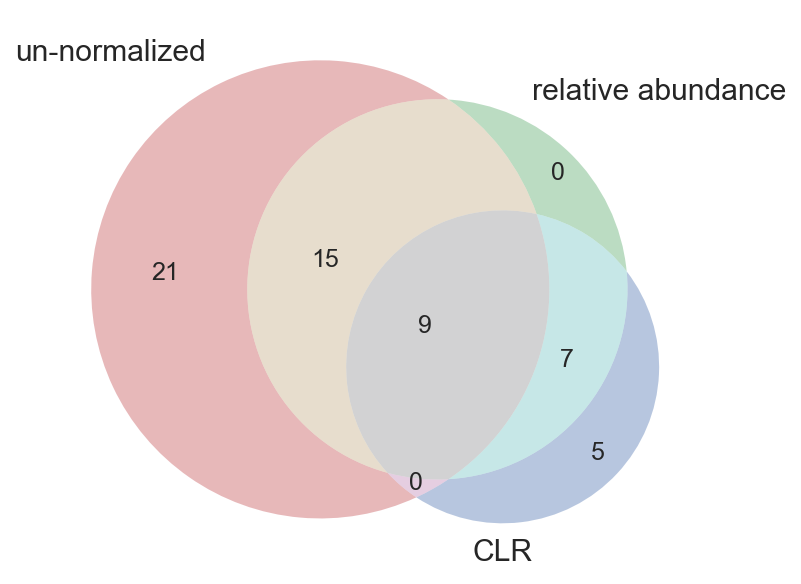

In [34]:
_ = venn3([set(v9_correlations.query('p_adj < .05').index), set(v9_correlations_rel.query('p_adj < .05').index), set(v9_correlations_clr.query('p_adj < .05').index)], set_labels=('un-normalized', 'relative abundance', 'CLR'))

The venn diagram shows the 10 that are shared by all. 20 are only in the normalized data. Relative abundance doesn't add anything unique and CLR adds two unique results.

PearsonRResult(statistic=0.5385890195125794, pvalue=1.0785552863603918e-09)

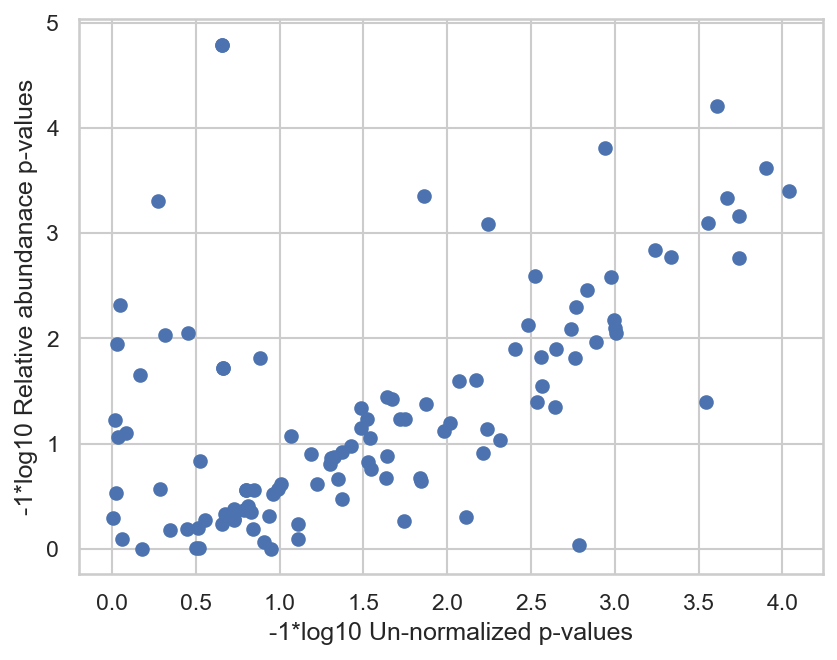

In [35]:
_ = plt.scatter(-1*np.log10(v9_correlations['p_value']), -1*np.log10(v9_correlations_rel.loc[v9_correlations.index, 'p_value']))
_ = plt.xlabel('-1*log10 Un-normalized p-values')
_ = plt.ylabel('-1*log10 Relative abundanace p-values')
pearsonr(-1*np.log10(v9_correlations['p_value']), -1*np.log10(v9_correlations_rel.loc[v9_correlations.index, 'p_value']))

Much worse correlation between normalization strategies at one year time point.

PearsonRResult(statistic=0.13878960742409188, pvalue=0.1462994527423617)

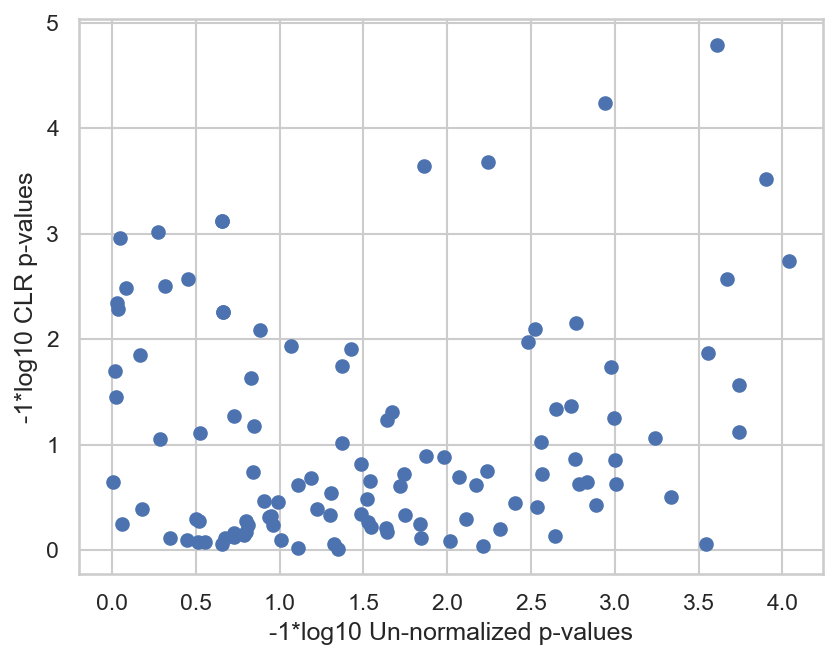

In [36]:
_ = plt.scatter(-1*np.log10(v9_correlations['p_value']), -1*np.log10(v9_correlations_clr.loc[v9_correlations.index, 'p_value']))
_ = plt.xlabel('-1*log10 Un-normalized p-values')
_ = plt.ylabel('-1*log10 CLR p-values')
pearsonr(-1*np.log10(v9_correlations['p_value']), -1*np.log10(v9_correlations_clr.loc[v9_correlations.index, 'p_value']))

Much worse correlation between normalization strategies at one year time point.

PearsonRResult(statistic=0.7595074551548853, pvalue=4.39265816060488e-22)

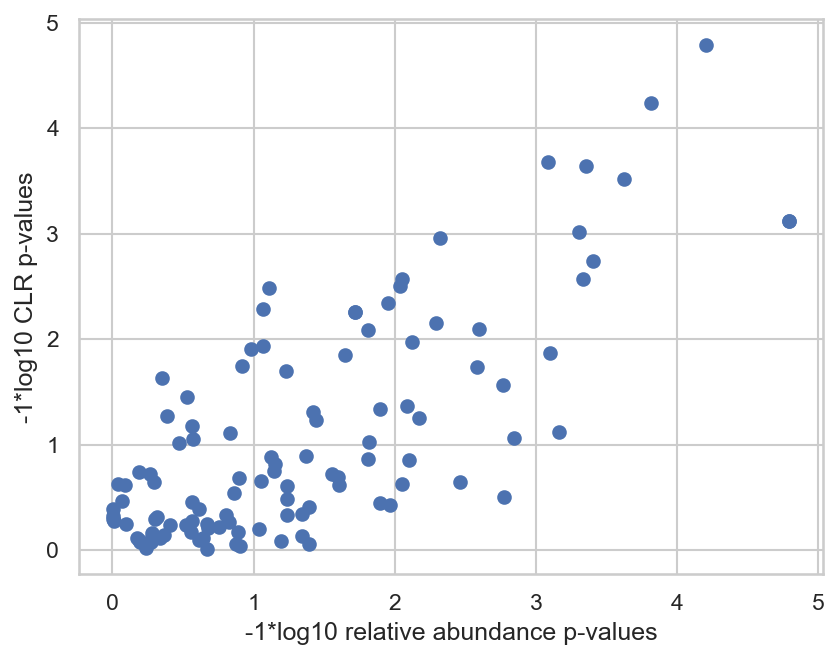

In [37]:
_ = plt.scatter(-1*np.log10(v9_correlations_rel['p_value']), -1*np.log10(v9_correlations_clr.loc[v9_correlations_rel.index, 'p_value']))
_ = plt.xlabel('-1*log10 relative abundance p-values')
_ = plt.ylabel('-1*log10 CLR p-values')
pearsonr(-1*np.log10(v9_correlations_rel['p_value']), -1*np.log10(v9_correlations_clr.loc[v9_correlations_rel.index, 'p_value']))

Much worse correlation between normalization strategies at one year time point.

## Plot tryptophan vs titers

This is the spike-in which was found to be significant at year 1.

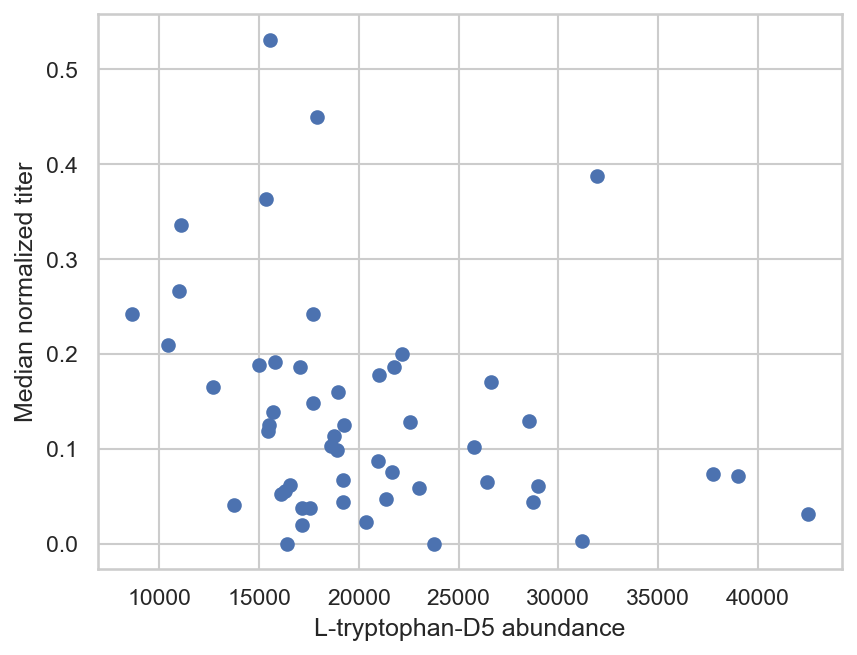

In [38]:
_ = plt.scatter(metab_data_v9.loc[meta_v9.index, 'L-tryptophan-D5'], meta_v9['median_mmNorm'])
_ = plt.xlabel('L-tryptophan-D5 abundance')
_ = plt.ylabel('Median normalized titer')

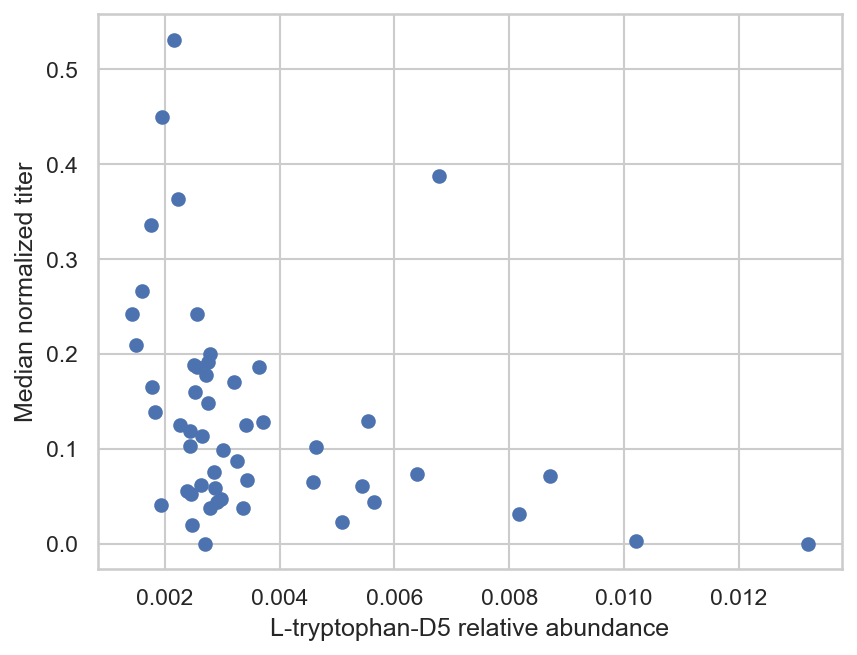

In [39]:
_ = plt.scatter(metab_data_rel_v9.loc[meta_v9.index, 'L-tryptophan-D5'], meta_v9['median_mmNorm'])
_ = plt.xlabel('L-tryptophan-D5 relative abundance')
_ = plt.ylabel('Median normalized titer')

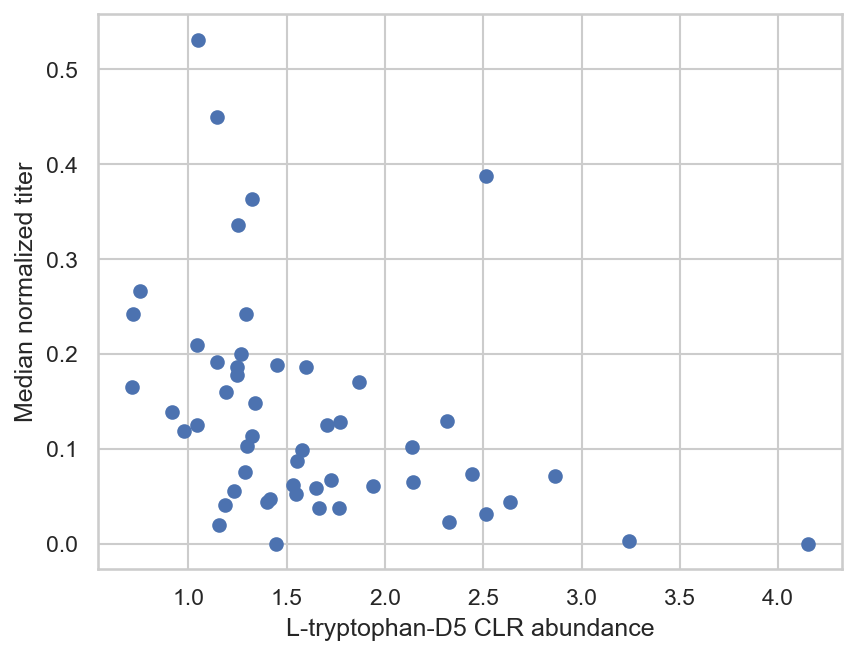

In [40]:
_ = plt.scatter(metab_data_clr_v9.loc[meta_v9.index, 'L-tryptophan-D5'], meta_v9['median_mmNorm'])
_ = plt.xlabel('L-tryptophan-D5 CLR abundance')
_ = plt.ylabel('Median normalized titer')

It looks pretty correlated no matter what normalization you use. This make me hesitant to use the 1 year time point metabolomics data.

## Correlate un-normalized with separate median titers

Now that we have looked at the combined median titers with both time points we will split into the DTAPHib and PCV medians separately.

### 2 month DTap hib

In [41]:
v5_DTAPHib_correlations = metab_data_v5.apply(spearmanr, b=meta_v5['median_mmNorm_DTAPHib']).transpose()
v5_DTAPHib_correlations.columns = ['rho', 'p_value']
v5_DTAPHib_correlations['p_adj'] = p_adjust(v5_DTAPHib_correlations['p_value'])
v5_DTAPHib_correlations = v5_DTAPHib_correlations.sort_values('p_value')
v5_DTAPHib_correlations.head()

,rho,p_value,p_adj
Pyruvic acid,-0.563852,0.000342,0.037958
Phenylpyruvic acid,-0.515191,0.001303,0.072309
Orotic acid,0.456488,0.005135,0.189994
Pyridoxal hydrochloride,0.435376,0.007956,0.191652
4-Pyridoxic acid,0.420958,0.010569,0.191652


Three things are significant after FDR correction when correlating 2 month titers with DTAPHib titers. Phenylpyruvic acid still and additionally pyruvic acid and 1-Methyl-1-butanol.

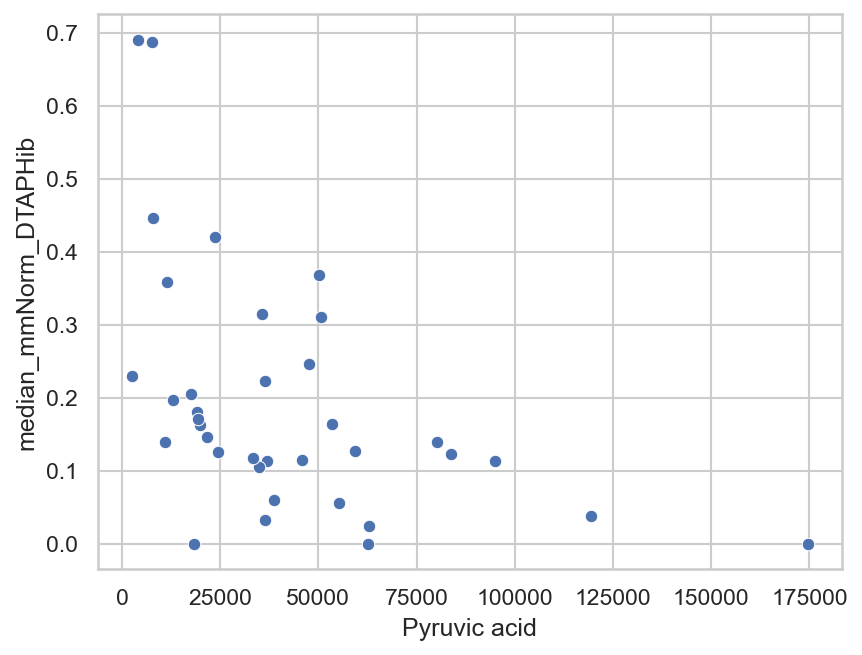

In [42]:
metab_data_v5_w_titer = metab_data_v5.copy()
metab_data_v5_w_titer['median_mmNorm_DTAPHib'] = meta_v5.loc[metab_data_v5_w_titer.index, 'median_mmNorm_DTAPHib']
_ = sns.scatterplot(x='Pyruvic acid', y='median_mmNorm_DTAPHib', data=metab_data_v5_w_titer)

Very similar curve to what we saw with phenylpyruvic acid with the median of all titers.

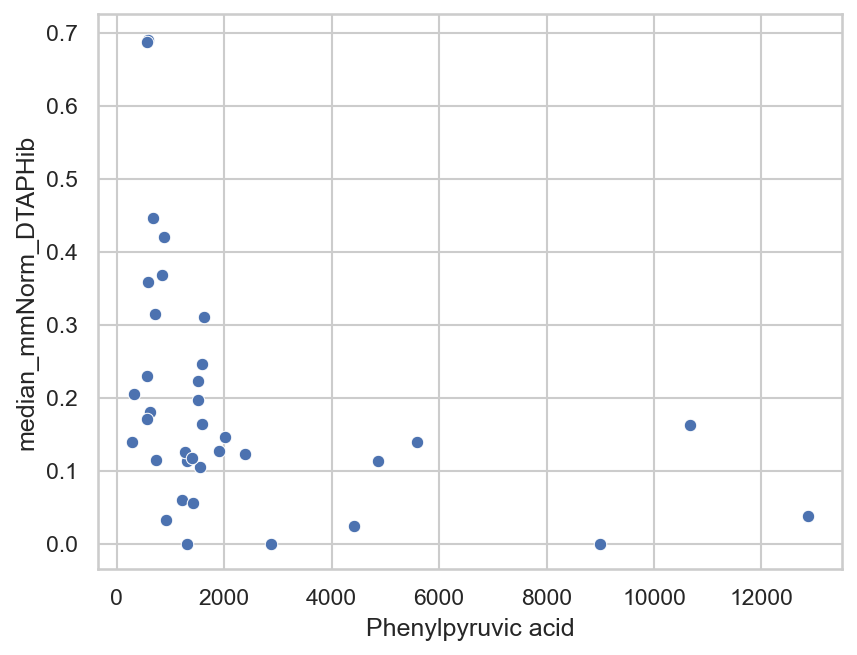

In [43]:
_ = sns.scatterplot(x='Phenylpyruvic acid', y='median_mmNorm_DTAPHib', data=metab_data_v5_w_titer)

Again very similar to the other significant curves. This one might be a bit more extreme/scattered. If you have < 2000 Phenylpyruvic acid acid then you are very likely to have high titers.

### 2 month PCV

Same idea as above but with the PCV titers instead of the DTapHib titers. There are two babies who have a median titer but do not have a median PCV titer because of a lack of measured PCV titers.

In [44]:
meta_PCV = meta_matched.loc[~pd.isna(meta_matched['median_mmNorm_PCV'])]
meta_PCV.head()

,BabyN,VisitCode,VisitDate,PT,Dip,FHA,PRN,TET,PRP (Hib),PCV ST1,...,median_mmNorm_PCV,median_mmNorm_DTAPHib,protectNorm_Dip,protectNorm_TET,protectNorm_PRP (Hib),protectNorm_PT,protectNorm_PRN,protectNorm_FHA,geommean_protectNorm,VR_group_v2
P125_V12_08212020,125,V12,08212020,2.5,0.05,8.0,16.0,0.6,1.88,159.800978,...,0.037553,0.147901,0.5,6.0,12.533333,0.3125,2.0,1.0,1.692432,NVR
P136_V5_12062019,136,V5,12062019,2.5,0.05,5.0,2.5,0.22,1.34,254.805233,...,0.120167,0.024566,0.5,2.2,8.933333,0.3125,0.3125,0.625,0.918328,LVR
P243_V5_09062018,243,V5,09062018,10.0,0.61,5.0,18.0,0.054,0.15,112.372819,...,0.056522,0.146771,6.1,0.54,1.0,1.25,2.25,0.625,1.340035,NVR
P233_V9_05232019,233,V9,05232019,9.0,0.94,14.0,43.0,3.51,1.38,344.0,...,0.165297,0.419887,9.4,35.1,9.2,1.125,5.375,1.75,5.63809,HVR
P204_V12_02112020,204,V12,02112020,2.5,0.4,41.0,5.0,NaN,NaN,399.0,...,0.37198,0.19273,4.0,NaN,NaN,0.3125,0.625,5.125,1.414559,LVR


In [45]:
meta_PCV_v5 = meta_PCV.query("VisitCode == 'V5'")
metab_data_PCV_v5 = metab_data.loc[meta_PCV_v5.index].transpose()
metab_data_PCV_v5 = metab_data_PCV_v5.loc[(metab_data_PCV_v5 > 0).sum(axis=1) > metab_data_PCV_v5.shape[1]*.2]
v5_PCV_correlations = metab_data_PCV_v5.transpose().apply(spearmanr, b=meta_PCV_v5['median_mmNorm_PCV']).transpose()
v5_PCV_correlations.columns = ['rho', 'p_value']
v5_PCV_correlations['p_adj'] = p_adjust(v5_PCV_correlations['p_value'])
v5_PCV_correlations = v5_PCV_correlations.sort_values('p_value')
v5_PCV_correlations.head()

,rho,p_value,p_adj
Phenylpyruvic acid,-0.670455,0.000020,0.002180
Deoxycytidine 5-triphosphate,0.542112,0.001119,0.062095
xanthurenic acid,-0.412099,0.017171,0.513376
Pyruvic acid,-0.407754,0.018500,0.513376
L-Serine,-0.382687,0.027946,0.519205


Only one significantly correlated with PCV and it's our friend Phenylpyruvic acid.

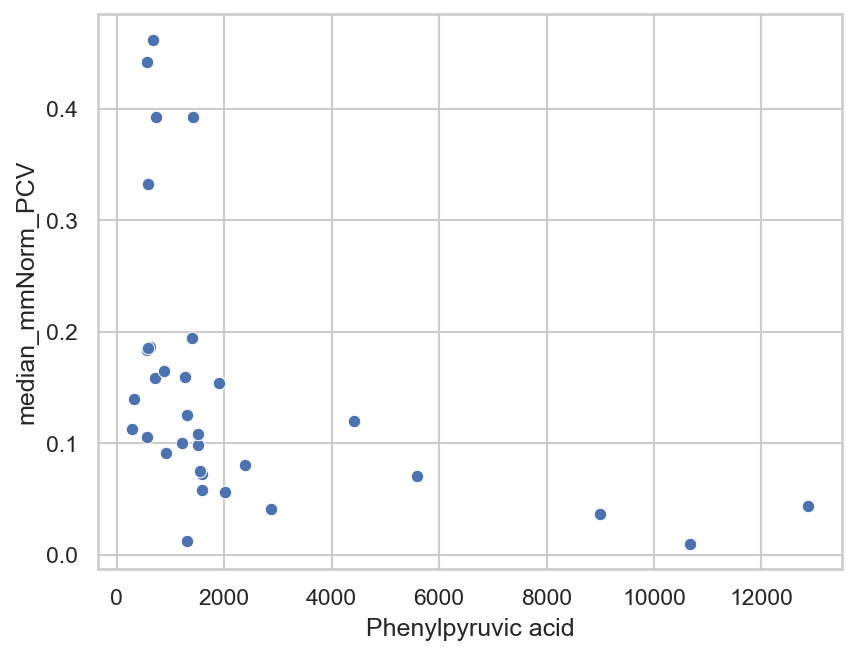

In [46]:
metab_data_PCV_v5_w_titer = metab_data_PCV_v5.copy().transpose()
metab_data_PCV_v5_w_titer['median_mmNorm_PCV'] = meta_v5.loc[metab_data_PCV_v5_w_titer.index, 'median_mmNorm_PCV']
# metab_data_PCV_v5_w_titer
_ = sns.scatterplot(x='Phenylpyruvic acid', y='median_mmNorm_PCV', data=metab_data_PCV_v5_w_titer)

Different compound same curve.

### 12 month DTAPHib

In [47]:
v9_DTAPHib_correlations = metab_data_v9.apply(spearmanr, b=meta_v9['median_mmNorm_DTAPHib']).transpose()
v9_DTAPHib_correlations.columns = ['rho', 'p_value']
v9_DTAPHib_correlations['p_adj'] = p_adjust(v9_DTAPHib_correlations['p_value'])
v9_DTAPHib_correlations = v9_DTAPHib_correlations.sort_values('p_value')
v9_DTAPHib_correlations.head(15)

,rho,p_value,p_adj
Guanosine,-0.553895,0.000020,0.000817
serotonin,0.551589,0.000023,0.000817
L-Serine,0.545952,0.000028,0.000817
hydroxyphenyllactate,0.545012,0.000029,0.000817
L-Isoleucine,0.527770,0.000058,0.001118
Creatinine,0.524023,0.000067,0.001118
Xanthine,0.522634,0.000071,0.001118
L-Phenylalanine,0.498377,0.000170,0.002252
L-Leucine,0.494886,0.000192,0.002252
L-Histidine,0.493263,0.000203,0.002252


Lots significant again. I don't trust these results.

### 12 month PCV

In [48]:
meta_PCV_v9 = meta_PCV.query("VisitCode == 'V9'")
metab_data_PCV_v9 = metab_data.loc[meta_PCV_v9.index].transpose()
metab_data_PCV_v9 = metab_data_PCV_v9.loc[(metab_data_PCV_v9 > 0).sum(axis=1) > metab_data_PCV_v9.shape[1]*.2]
v9_PCV_correlations = metab_data_PCV_v9.transpose().apply(spearmanr, b=meta_PCV_v9['median_mmNorm_PCV']).transpose()
v9_PCV_correlations.columns = ['rho', 'p_value']
v9_PCV_correlations['p_adj'] = p_adjust(v9_PCV_correlations['p_value'])
v9_PCV_correlations = v9_PCV_correlations.sort_values('p_value')
v9_PCV_correlations.head(15)

,rho,p_value,p_adj
Xanthine,0.449231,0.000944,0.025887
serotonin,0.447873,0.000982,0.025887
L-Phenylalanine,0.441991,0.001165,0.025887
L-Proline,0.430860,0.001598,0.025887
L-Isoleucine,0.430372,0.001620,0.025887
Creatinine,0.423549,0.001955,0.025887
L-Serine,0.421810,0.002050,0.025887
Riboflavin,0.421196,0.002084,0.025887
L-Leucine,0.415847,0.002406,0.025887
Phenaceturic acid,0.410769,0.002752,0.025887


Lots significant again. I don't trust these results.

## Correlate relative abundance with separate median titers

Now we will do the same thing but with relative abundance for PCV and DTAPHib.

### 2 month DTAPHib

In [49]:
v5_DTAPHib_correlations_rel = metab_data_rel_v5.apply(spearmanr, b=meta_v5['median_mmNorm_DTAPHib']).transpose()
v5_DTAPHib_correlations_rel.columns = ['rho', 'p_value']
v5_DTAPHib_correlations_rel['p_adj'] = p_adjust(v5_DTAPHib_correlations_rel['p_value'])
v5_DTAPHib_correlations_rel = v5_DTAPHib_correlations_rel.sort_values('p_value')
v5_DTAPHib_correlations_rel.head()

,rho,p_value,p_adj
Pyruvic acid,-0.557415,0.000413,0.045845
Phenylpyruvic acid,-0.523944,0.001039,0.057680
Pyridoxal hydrochloride,0.470906,0.003747,0.138651
4-Pyridoxic acid,0.439238,0.007359,0.176632
Orotic acid,0.435376,0.007956,0.176632


Same three compounds.

### 2 month PCV

In [50]:
metab_data_PCV_rel_v5 = metab_data_rel.loc[meta_PCV_v5.index].transpose()
v5_PCV_correlations_rel = metab_data_PCV_rel_v5.transpose().apply(spearmanr, b=meta_PCV_v5['median_mmNorm_PCV']).transpose()
v5_PCV_correlations_rel.columns = ['rho', 'p_value']
v5_PCV_correlations_rel['p_adj'] = p_adjust(v5_PCV_correlations_rel['p_value'])
v5_PCV_correlations_rel = v5_PCV_correlations_rel.sort_values('p_value')
v5_PCV_correlations_rel.head()

,rho,p_value,p_adj
Phenylpyruvic acid,-0.627340,0.000093,0.010361
Deoxycytidine 5-triphosphate,0.500334,0.003025,0.167868
myo-Inositol,0.408422,0.018290,0.462587
D-Mannose,0.372660,0.032693,0.462587
L-Serine,-0.372660,0.032693,0.462587


Just phenylpyruvic acid.

### 12 month DTAPHib

In [51]:
v9_DTAPHib_correlations_rel = metab_data_rel_v9.apply(spearmanr, b=meta_v9['median_mmNorm_DTAPHib']).transpose()
v9_DTAPHib_correlations_rel.columns = ['rho', 'p_value']
v9_DTAPHib_correlations_rel['p_adj'] = p_adjust(v9_DTAPHib_correlations_rel['p_value'])
v9_DTAPHib_correlations_rel = v9_DTAPHib_correlations_rel.sort_values('p_value')
v9_DTAPHib_correlations_rel.head(25)

,rho,p_value,p_adj
Guanosine,-0.594124,0.000003,0.000381
serotonin,0.552870,0.000021,0.001185
L-tryptophan-D5,-0.527417,0.000059,0.001570
Inosine,-0.521609,0.000073,0.001570
D-Mannose,-0.517680,0.000085,0.001570
L-Sorbose,-0.517680,0.000085,0.001570
Adenosine,-0.500085,0.000160,0.002538
L-Kynurenine,0.494448,0.000195,0.002654
L-Serine,0.491544,0.000215,0.002654
Xanthine,0.468312,0.000463,0.005140


Lots significant again. I don't trust these results.

### 12 month PCV

In [52]:
metab_data_PCV_rel_v9 = metab_data_rel.loc[meta_PCV_v9.index].transpose()
v9_PCV_correlations_rel = metab_data_PCV_rel_v9.transpose().apply(spearmanr, b=meta_PCV_v9['median_mmNorm_PCV']).transpose()
v9_PCV_correlations_rel.columns = ['rho', 'p_value']
v9_PCV_correlations_rel['p_adj'] = p_adjust(v9_PCV_correlations_rel['p_value'])
v9_PCV_correlations_rel = v9_PCV_correlations_rel.sort_values('p_value')
v9_PCV_correlations_rel.head(13)

,rho,p_value,p_adj
L-Sorbose,-0.485882,0.000301,0.016703
D-Mannose,-0.485882,0.000301,0.016703
Adenosine,-0.465068,0.000585,0.021644
Guanosine,-0.443258,0.001124,0.031180
serotonin,0.423710,0.001947,0.040099
myo-Inositol,-0.410679,0.002759,0.040099
L-Phenylalanine,0.402805,0.003384,0.040099
L-Isoleucine,0.401357,0.003511,0.040099
L-Proline,0.400452,0.003593,0.040099
Riboflavin,0.396833,0.003938,0.040099


Lots significant again. I don't trust these results.

## Correlate CLR with separate median titers

### 2 month correlations

In [53]:
v5_DTAPHib_correlations_clr = metab_data_clr_v5.apply(spearmanr, b=meta_v5['median_mmNorm_DTAPHib']).transpose()
v5_DTAPHib_correlations_clr.columns = ['rho', 'p_value']
v5_DTAPHib_correlations_clr['p_adj'] = p_adjust(v5_DTAPHib_correlations_clr['p_value'])
v5_DTAPHib_correlations_clr = v5_DTAPHib_correlations_clr.sort_values('p_value')
v5_DTAPHib_correlations_clr.head(8)

,rho,p_value,p_adj
Pyridoxal hydrochloride,0.550721,0.000501,0.039113
Pyruvic acid,-0.532698,0.000824,0.039113
Phenylpyruvic acid,-0.517765,0.001220,0.039113
Orotic acid,0.510041,0.001484,0.039113
4-Pyridoxic acid,0.499743,0.001914,0.039113
Creatine,0.495623,0.002114,0.039113
Thymine,0.405767,0.014075,0.223191
5-HIAA,-0.396756,0.016585,0.230116


In [54]:
metab_data_PCV_clr_v5 = metab_data_clr.loc[meta_PCV_v5.index].transpose()
v5_PCV_correlations_clr = metab_data_PCV_clr_v5.transpose().apply(spearmanr, b=meta_PCV_v5['median_mmNorm_PCV']).transpose()
v5_PCV_correlations_clr.columns = ['rho', 'p_value']
v5_PCV_correlations_clr['p_adj'] = p_adjust(v5_PCV_correlations_clr['p_value'])
v5_PCV_correlations_clr = v5_PCV_correlations_clr.sort_values('p_value')
v5_PCV_correlations_clr.head()

,rho,p_value,p_adj
Phenylpyruvic acid,-0.658422,0.000031,0.003452
Deoxycytidine 5-triphosphate,0.406083,0.019034,0.514584
myo-Inositol,0.404746,0.019470,0.514584
L-tryptophan-D5,0.369652,0.034238,0.514584
L-Sorbose,0.364973,0.036760,0.514584


Same results as all other 2 month correlations for DTAPHib and PCV.

### 12 month correlations

In [55]:
v9_DTAPHib_correlations_clr = metab_data_clr_v9.apply(spearmanr, b=meta_v9['median_mmNorm_DTAPHib']).transpose()
v9_DTAPHib_correlations_clr.columns = ['rho', 'p_value']
v9_DTAPHib_correlations_clr['p_adj'] = p_adjust(v9_DTAPHib_correlations_clr['p_value'])
v9_DTAPHib_correlations_clr = v9_DTAPHib_correlations_clr.sort_values('p_value')
v9_DTAPHib_correlations_clr.head(27)

,rho,p_value,p_adj
Guanosine,-0.618808,0.000001,0.000112
L-tryptophan-D5,-0.559617,0.000016,0.000647
Inosine,-0.557653,0.000017,0.000647
Adenosine,-0.543731,0.000031,0.000861
serotonin,0.527844,0.000058,0.001285
2-3-Dihydroxyisovalerate,-0.502050,0.000149,0.002763
L-Sorbose,-0.489494,0.000231,0.003201
D-Mannose,-0.489494,0.000231,0.003201
D-Xylose,-0.483686,0.000281,0.003460
Succinic acid,-0.467458,0.000476,0.004854


In [56]:
metab_data_PCV_clr_v9 = metab_data_clr.loc[meta_PCV_v9.index].transpose()
v9_PCV_correlations_clr = metab_data_PCV_clr_v9.transpose().apply(spearmanr, b=meta_PCV_v9['median_mmNorm_PCV']).transpose()
v9_PCV_correlations_clr.columns = ['rho', 'p_value']
v9_PCV_correlations_clr['p_adj'] = p_adjust(v9_PCV_correlations_clr['p_value'])
v9_PCV_correlations_clr = v9_PCV_correlations_clr.sort_values('p_value')
v9_PCV_correlations_clr.head()

,rho,p_value,p_adj
Adenosine,-0.480181,0.000363,0.021900
Guanosine,-0.477557,0.000395,0.021900
serotonin,0.429050,0.001681,0.062183
Inosine,-0.415113,0.002454,0.068096
L-tryptophan-D5,-0.392851,0.004350,0.078341


Lots significant again. I don't trust these results.

## Compare normalizations for split titers

Build up some venn diagrams to compare normalizations for the split titers.

/Users/shaffmic/miniconda3/envs/imc/lib/python3.9/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


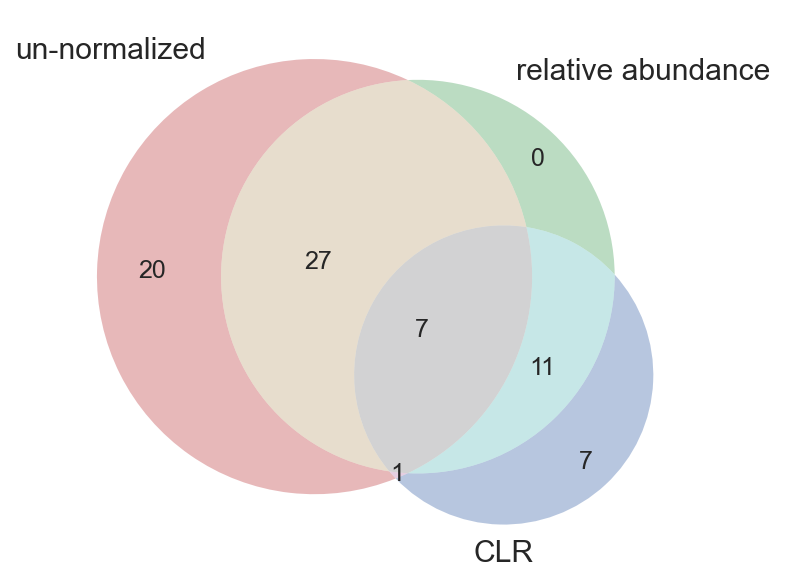

In [57]:
_ = venn3([set(v9_DTAPHib_correlations.query('p_adj < .05').index),
           set(v9_DTAPHib_correlations_rel.query('p_adj < .05').index),
           set(v9_DTAPHib_correlations_clr.query('p_adj < .05').index)], set_labels=('un-normalized',
                                                                                     'relative abundance', 'CLR'))

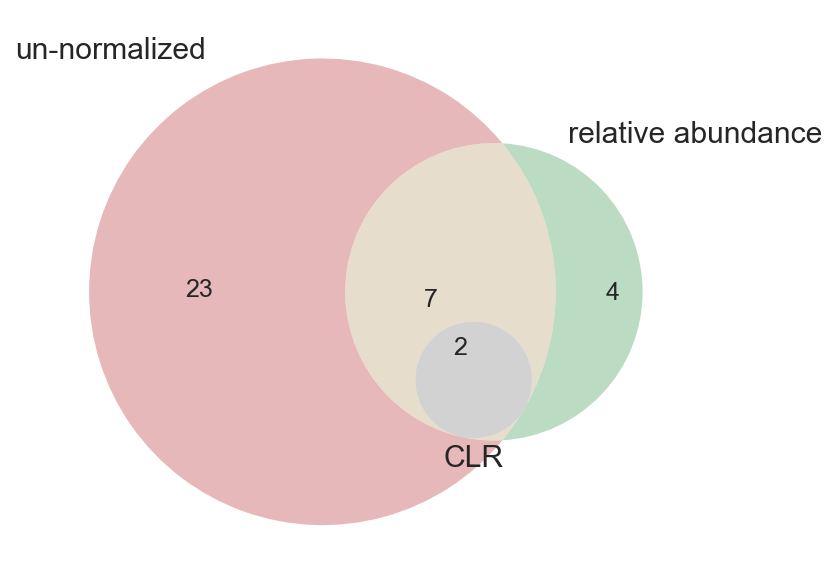

In [58]:
_ = venn3([set(v9_PCV_correlations.query('p_adj < .05').index),
           set(v9_PCV_correlations_rel.query('p_adj < .05').index),
           set(v9_PCV_correlations_clr.query('p_adj < .05').index)], set_labels=('un-normalized',
                                                                                     'relative abundance', 'CLR'))